In [1]:
# For Caffe Models, we can directly use OpenCV method cv2.dnn.readNetFromCaffe() without having to use Keras
import numpy as np
import cv2
import io
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

In [2]:
# Load preprocess and convert image to BLOB

# Load the image to detect, get width, height
img_to_detect = cv2.imread('cv2-source-code/images/testing/scene3.jpg')
img_height = img_to_detect.shape[0]
img_width = img_to_detect.shape[1]

# convert to blob to pass into model
img_blob = cv2.dnn.blobFromImage(img_to_detect, 0.003922, (416, 416), swapRB=True, crop=False)
# Recommended by yolo authors, scale factor is 0.003922 = 1/255, width, height of blob is 320 x 320
# Accepted sizes are 320x320, 416x416, 609x609. More size more more accuracy, but speed degraded 

In [3]:
# set of 80 class labels 
class_labels = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
                "trafficlight","firehydrant","stopsign","parkingmeter","bench","bird","cat",
                "dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack",
                "umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball",
                "kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket",
                "bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple",
                "sandwich","orange","broccoli","carrot","hotdog","pizza","donut","cake","chair",
                "sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse",
                "remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator",
                "book","clock","vase","scissors","teddybear","hairdrier","toothbrush"]

#Declare List of colors as an array
#Green, Blue, Red, cyan, yellow, purple
#Split based on ',' and for every split, change type to int
#convert that to a numpy array to apply color mask to the image numpy array
class_colors = ["0,255,0", "0,0,255", "255,0,0", "255,255,0", "0,255,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)
class_colors = np.tile(class_colors,(16,1))

In [4]:
# Load pre-trained model and get prediction

# loading pretrained model from cfg and weights files
yolo_model = cv2.dnn.readNetFromDarknet('cv2-source-code/dataset/yolov4.cfg','cv2-source-code/dataset/yolov4.weights')

# Get all layers from the yolo network
# Loop and find the last layer (output layer) of the yolo network 
# API - https://docs.opencv.org/5.x/db/d30/classcv_1_1dnn_1_1Net.html#ae8be9806024a0d1d41aba687cce99e6b
yolo_layers = yolo_model.getLayerNames()
yolo_output_layer = [yolo_layers[yolo_layer - 1] for yolo_layer in yolo_model.getUnconnectedOutLayers()]

# input preprocessed blob into model and pass through the model
yolo_model.setInput(img_blob)

# obtain the detection layers by forwarding through till the output layer
obj_detection_layers = yolo_model.forward(yolo_output_layer)

In [5]:
# loop over each of the layer outputs
for object_detection_layer in obj_detection_layers:
	# loop over the detections
  for object_detection in object_detection_layer:

    # obj_detections[1 to 4] => will have the two center points, box width and box height
    # obj_detections[5] => will have scores for all objects within bounding box
    all_scores = object_detection[5:]
    predicted_class_id = np.argmax(all_scores)
    prediction_confidence = all_scores[predicted_class_id]

    # take only predictions with confidence more than 50%
    if prediction_confidence > 0.50:
      #get the predicted label
      predicted_class_label = class_labels[predicted_class_id]
      #obtain the bounding box co-oridnates for actual image from resized image size
      bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
      (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
      start_x_pt = int(box_center_x_pt - (box_width / 2))
      start_y_pt = int(box_center_y_pt - (box_height / 2))
      end_x_pt = start_x_pt + box_width
      end_y_pt = start_y_pt + box_height

      #get a random mask color from the numpy array of colors
      box_color = class_colors[predicted_class_id]

      #convert the color numpy array as a list and apply to text and box
      box_color = [int(c) for c in box_color]

      # print the prediction in console
      predicted_class_label = "{}: {:.2f}%".format(predicted_class_label, prediction_confidence * 100)
      print("predicted object {}".format(predicted_class_label))

      # draw rectangle and text in the image
      cv2.rectangle(img_to_detect, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 1)
      cv2.putText(img_to_detect, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)

cv2.imshow("Detection Output", img_to_detect)


predicted object trafficlight: 50.24%
predicted object trafficlight: 50.84%
predicted object trafficlight: 64.50%
predicted object trafficlight: 64.04%
predicted object trafficlight: 57.88%
predicted object trafficlight: 56.96%
predicted object trafficlight: 78.93%
predicted object trafficlight: 84.21%
predicted object trafficlight: 83.86%
predicted object trafficlight: 93.33%
predicted object trafficlight: 93.12%
predicted object bus: 86.87%
predicted object bus: 74.39%
predicted object person: 54.49%
predicted object person: 66.56%
predicted object car: 95.06%
predicted object car: 95.68%
predicted object car: 95.27%
predicted object car: 99.17%
predicted object car: 99.20%
predicted object backpack: 51.33%
predicted object backpack: 51.70%
predicted object person: 69.07%
predicted object car: 81.42%
predicted object car: 91.67%
predicted object car: 68.89%
predicted object car: 98.62%
predicted object person: 63.69%
predicted object car: 69.52%
predicted object bicycle: 92.56%
predi

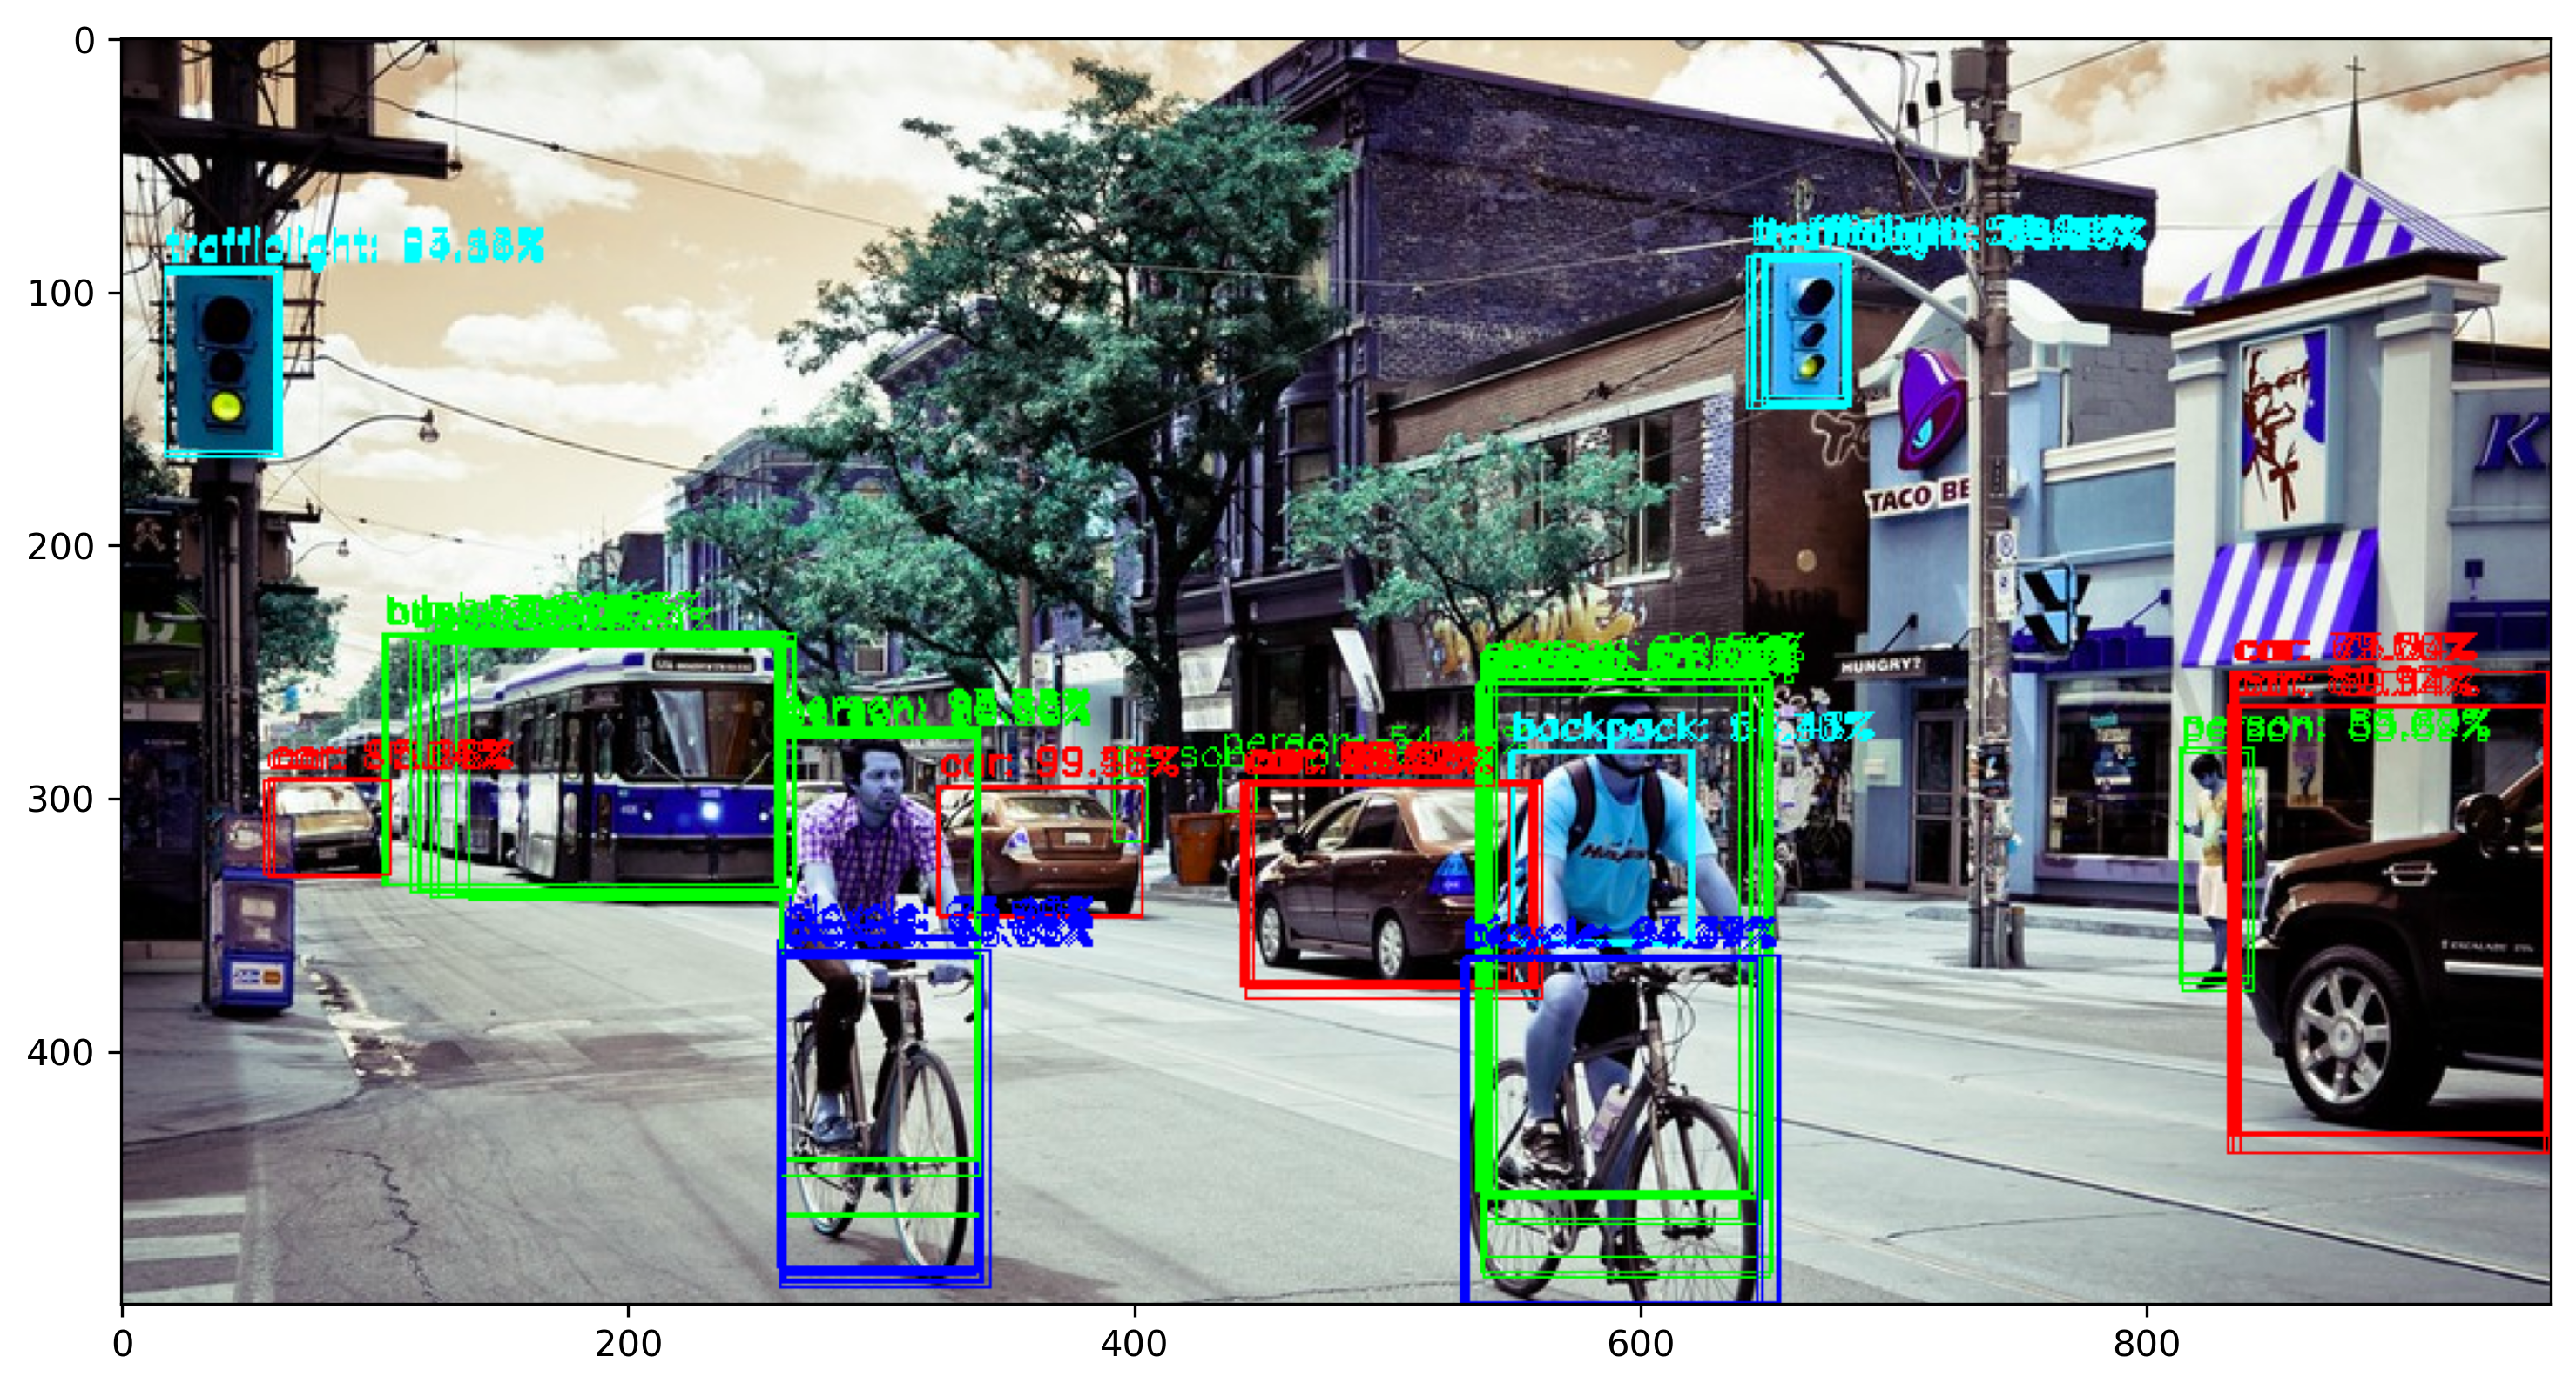

In [8]:
# show the output
# cv2.imshow("Detection Output", img_to_detect)
fig=plt.figure(figsize=(12, 8), dpi= 300)
plt.imshow(img_to_detect)
plt.show()

In [7]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))